# Flux measurements training SFERA-III STT16
Anita Haeussler, PROMES Laboratory

![](https://user-images.githubusercontent.com/102672251/273207866-dcb95a2f-e0ce-4be5-98be-cffc38b9d398.png)
![promes_haute_resolution](https://user-images.githubusercontent.com/102672251/273208814-195fb560-b728-41a4-9fca-87c122d2ae3e.jpg)
![cnrs](https://user-images.githubusercontent.com/102672251/273209781-d2635dca-5fa4-4ec4-be24-85547c09adbb.png)

# Principe of spatial calibration
Spatial calibration involves determining the distance represented by a pixel through the analysis of an image containing an object with known dimensions. The checkboard target used is shown below.
![checkboard](https://user-images.githubusercontent.com/102672251/273209215-775d3a75-ee59-4a4a-b050-68f03a62bd6a.png)

## Packages used

In [2]:
# System interphase
import os
# Warning management
import warnings
# Images management
import cv2
# Matrice management
import numpy as np
# Graphic
import matplotlib.pyplot as plt
# Copy list
from copy import deepcopy
# Color palettes
import seaborn as sns
# To import (homemade) jupyter Notebooks
import import_ipynb
import importlib


# Homemade notebooks
import general_functions as functions

importing Jupyter notebook from general_functions.ipynb


In [3]:
import general_functions as functions
importlib.reload(functions)

importing Jupyter notebook from general_functions.ipynb


<module 'general_functions' from 'general_functions.ipynb'>

## Constants

In [4]:
# Distance between 2 points on the checkboard
DIST_BTW_2POINTS = 1e-2 #(m)

## Read spatial target image  

In [5]:
# Path  of the folder
checkboard_folder = os.path.join(functions.FOLDER_PATH, "checkboard")
# Names of the images
checkboard_names = [name for name in os.listdir(checkboard_folder)
             if name.endswith(".tiff")]
# print(checkboard_names)
# Path of the checkboard image 
checkboard_path = os.path.join(checkboard_folder, checkboard_names[0])
# Read the image
checkboard_raw = cv2.imread(checkboard_path, -1)
# Convert the image to grey value
checkboard_img =  cv2.cvtColor(checkboard_raw, cv2.COLOR_BGR2GRAY)
# # Convert to  0 - 255
checkboard_img = np.intc(checkboard_img/np.amax(checkboard_img)*255)
# # Convert to 8 bits
checkboard_img = checkboard_img.astype('uint8')

## Display

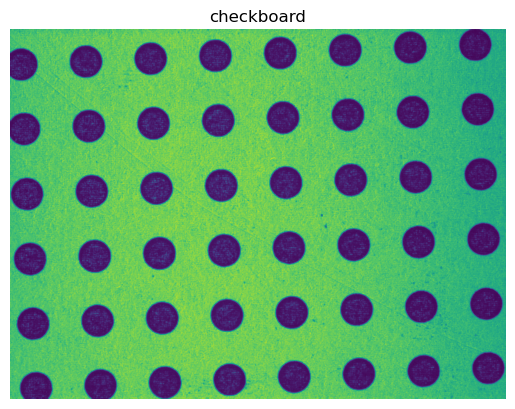

In [6]:
if __name__ == "__main__":
    fig = plt.figure()
    plt.imshow(checkboard_img)
    plt.title("checkboard")
    plt.axis("off")
    plt.show()

## Circle detection
In this section, the circles on the checkboard are detected with SimpleBlobDetector
Use SimpleBlobDetector, 
cf : https://learnopencv.com/blob-detection-using-opencv-python-c/

In [7]:
params = cv2.SimpleBlobDetector_Params()
params.filterByCircularity = True
params.minCircularity = 0.7
params.maxCircularity = 1
params.filterByArea = True
params.minArea = 50
params.maxArea = 100000
ver = (cv2.__version__).split('.')
if int(ver[0]) < 3 :
    detector = cv2.SimpleBlobDetector(params)
else :
    detector = cv2.SimpleBlobDetector_create(params)
# Circles detection on the checkboard image
keypoints = detector.detect(checkboard_img)
# Formatting the coordinate
circle_coords = [[keypoints[idx].pt[0], keypoints[idx].pt[1], keypoints[idx].size] for idx in range(len(keypoints))]
dt = {'names': ['center_X', 'centerY', 'diameter'], 'formats': [float, float]}
circle_coords = np.asarray(circle_coords, np.float64)
# Average of the circle diameters
_, _, circle_diam = np.mean(circle_coords, axis=0)
# Average of the circle radius
circle_radius = circle_diam/2   

## Display

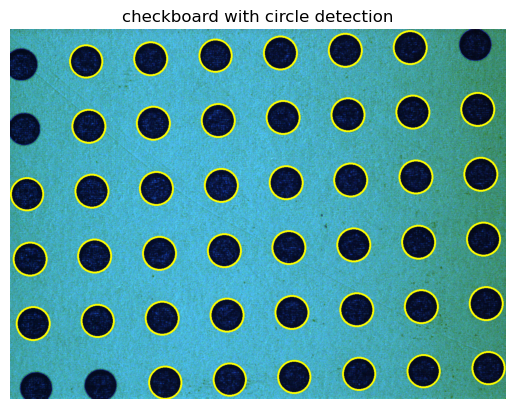

In [8]:
if __name__ == "__main__":
    checkboard_disp = checkboard_raw.copy()
    checkboard_disp = np.intc(checkboard_disp/2**11*255)
    # # Convert to 8 bits
    checkboard_disp = checkboard_disp.astype('uint8')
    idx = 0
    for centre_X, centre_Y, diametre in np.round(circle_coords).astype("int"):
        idx +=1
        cv2.circle(checkboard_disp, (centre_X, centre_Y), int(diametre/2), (255, 255, 0), 4)
    plt.imshow(checkboard_disp)
    plt.axis("Off")
    plt.title("checkboard with circle detection")
    plt.show()

### But ...
This code returns the list of circles without ordering them in relation to each other. This does not (yet) allow you to obtain the number of pixels separating each point.

-> Ordering the circle in a matrix

In [9]:
if __name__ == "__main__":
    print(circle_coords)

[[ 403.52459717  920.51617432   83.68898773]
 [ 571.85668945  913.21392822   84.99829865]
 [ 740.05609131  905.75         85.06650543]
 [ 908.71575928  898.29333496   85.41769409]
 [1077.22631836  890.64752197   85.47922516]
 [1245.7911377   883.00830078   85.03702545]
 [  59.66518402  767.08673096   85.54147339]
 [ 227.81536865  759.9241333    85.16454315]
 [ 396.09109497  752.65515137   85.81954956]
 [ 565.01898193  745.42926025   85.93533325]
 [ 733.76049805  738.02624512   86.1616745 ]
 [ 902.75750732  730.52148438   85.74972534]
 [1071.27612305  723.03674316   85.66333008]
 [1240.35107422  715.39135742   85.79515839]
 [  51.85272598  598.72955322   86.08336639]
 [ 220.27865601  591.41802979   86.05214691]
 [ 388.83013916  583.91882324   86.27607727]
 [ 557.67242432  576.59234619   86.25995636]
 [ 726.33630371  569.27294922   86.38925171]
 [ 895.10443115  561.92468262   86.15484619]
 [1063.9453125   554.58734131   86.60506439]
 [1233.11621094  546.87329102   86.31705475]
 [  43.920

## Circle arrangement
This code progressively organizes circles into columns according to their position along the y and x axes, starting with the first column. Circles already placed in a column are removed from the list of unsorted circles to ensure that they are not 

In [10]:
non_ordered_cicles = deepcopy(circle_coords)
# Creation of a list of column 
cols = []
# Arrangement along y axis
non_ordered_cicles = functions.order_along_y(non_ordered_cicles)
# y difference with the first circle of the list
y_diff = abs(non_ordered_cicles[:, 0] - non_ordered_cicles[0, 0])
# Set the column with the circles aligned 
first_col = non_ordered_cicles[y_diff < circle_radius]
# Arrangement along x axis
first_col = functions.order_along_x(first_col)
# Add to the column list
cols.append(first_col)
# Delete the circles already agencing
non_ordered_cicles = np.delete(non_ordered_cicles,
                          range(first_col.shape[0]), axis=0)

## Display

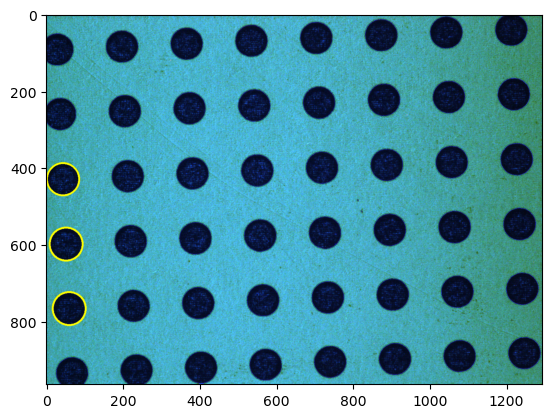

In [11]:
if __name__ == "__main__":
    checkboard_disp = checkboard_raw.copy()
    checkboard_disp = np.intc(checkboard_disp/2**11*255)
    # # Convert to 8 bits
    checkboard_disp = checkboard_disp.astype('uint8')
    idx = 0
    for centre_X, centre_Y, diametre in np.round(first_col).astype("int"):
        idx +=1
        cv2.circle(checkboard_disp, (centre_X, centre_Y), int(diametre/2), (255, 255, 0), 4)
    plt.imshow(checkboard_disp)
    plt.show()

## Creations of the other columns with same principle

In [12]:
while 1:
    y_diff = abs(non_ordered_cicles[:, 0] - non_ordered_cicles[0, 0])
    # Set the column with the circles aligned 
    col = non_ordered_cicles[y_diff < circle_radius]
    # Arrangement along x axis
    col = functions.order_along_x(col)
    # Add to the column list
    cols.append(col)
    # Delete the circles already agencing
    non_ordered_cicles = np.delete(non_ordered_cicles,
                                   range(col.shape[0]), axis=0)
    if non_ordered_cicles.shape[0] == 0:
        break

## Display

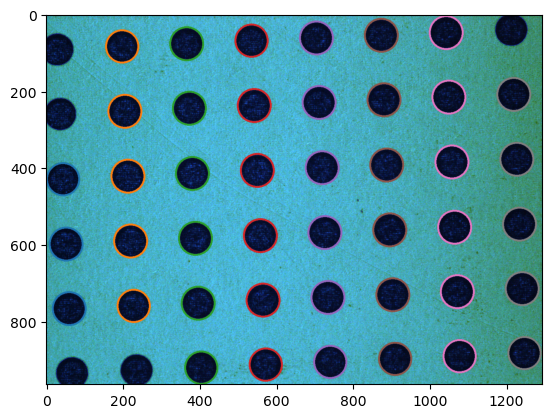

In [13]:
if __name__ == "__main__":
    checkboard_disp = checkboard_raw.copy()
    checkboard_disp = np.intc(checkboard_disp/2**11*255)
    # # Convert to 8 bits
    checkboard_disp = checkboard_disp.astype('uint8')
    colors = sns.color_palette("tab10")
    for idx, col in enumerate(cols):
        for centre_X, centre_Y, diametre in np.round(col).astype("int"):
            color = (colors[idx][0]*255, colors[idx][1]*255, colors[idx][2]*255)
            cv2.circle(checkboard_disp, (centre_X, centre_Y), int(diametre/2), color, 4)
    plt.imshow(checkboard_disp)
    plt.show()

## Ordering circle in matrix

In [14]:
# Get the number of columns in the data
nb_cols = len(cols)
# Find the maximum number of rows among all columns
nb_lines = max([len(cols[idx])
                for idx in range(0, nb_cols)])
# Create a matrix to store circle data (3 columns: x, y, z)
circles_mat = np.zeros((nb_lines, nb_cols, 3))
# Fill matrix with NaN values (not available)
circles_mat[:] = np.nan
# Ignore RuntimeWarning warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
# Copy column data to a new variable
columns_data =  deepcopy(cols)
# Line index where to store data in the circles_mat matrix
idy = nb_lines
# Indicate whether all circles are ordered
all_circles_ordered = False
# Main loop for ordering circles
while 1:
    # Find the column with the lowest circle
    col_lower_circle = np.nanargmax([np.nanmax(col, axis=0)[1] for col in columns_data])
    # Find the line with the lowest circle in this column
    line_lowest_circle = np.nanargmax(columns_data[col_lower_circle], axis=0)[1]
    # Copy the lowest circle
    lowest_circle = deepcopy(columns_data[col_lower_circle][line_lowest_circle])
    idy = idy-1
    # Browse column data to find matching circles
    for idx1, col in enumerate(columns_data):
        for idx2 in range(len(col)):
            if abs(lowest_circle[1]-col[idx2][1])< circle_diam:
                # Store the corresponding circle in the circle matrix
                circles_mat[idy, idx1, :] = col[idx2]
                # Mark the circle as processed by setting the column data to NaN
                columns_data[idx1][idx2] = [np.nan, np.nan, np.nan]
    # Check that all circles are ordered (all columns are NaN)
    all_circles_ordered = all([np.isnan(col).all() for col in columns_data])
    # Exit the loop if all circles are ordered
    if all_circles_ordered==True:
        break

## Display

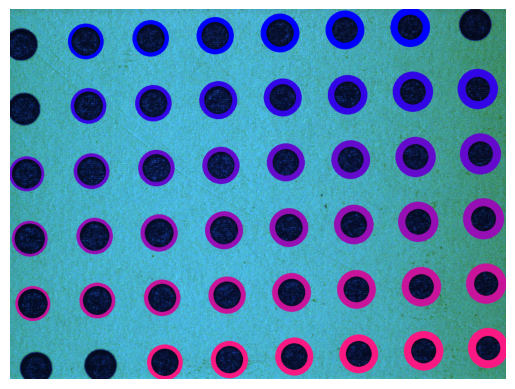

In [15]:
if __name__ == "__main__":
    checkboard_disp = checkboard_raw.copy()
    checkboard_disp = np.intc(checkboard_disp/2**11*255)
    # # Convert to 8 bits
    checkboard_disp = checkboard_disp.astype('uint8')
    for idx in range(circles_mat.shape[0]):
        for idx_i in range(circles_mat.shape[1]):
            color = (idx*50, idx*5, 255-idx*25)       
            centre_X, centre_Y, diametre = circles_mat[idx, idx_i, :]
            try:
                cv2.circle(checkboard_disp, (int(centre_X), int(centre_Y)), int(diametre/2), color, 5+idx_i*2)
            except ValueError:
                pass
    plt.imshow(checkboard_disp)
    plt.axis("off")
    plt.show()

## Calculation of the pixel distances between closest neighbors circles
To calculate the number of pixels  between consecutive sets of centers of circles, the `circles_mat` is used. The method to compute the number of pixels between consecutive sets of centers of circles which are horizontally aligned is schematized in the fiugre below. 
First to compute the number of pixels between to circles $C_1$ and $C_2$, the following formula is used :
$nb_{pix} = \sqrt{(x_1-x_2)^2+(y_1-y_2)^2} $. 
The function `calculate_distances_between_point_sets` uses this formula to calculate a set of number of pixels between a set of circles.

A submatrix containing the left points $M_{left \ circles}$  is created from the `circles_mat` matrix by removing the last column. A second submatrix containing the left points $M_{right \ circles}$  is created from the `circles_mat` matrix by removing the first column. Then $M_{left \ circles}$ and $M_{right \ circles}$ are inputed in `calculate_distances_between_point_sets` which allows to obtain the number of pixels between consecutive sets of centers of circles which are horizontally.


![calcul_distance](https://user-images.githubusercontent.com/102672251/273209296-79fcce1b-d0b6-4872-9c44-b75745730794.png)

A similar method is apply to compute the number of pixel between consecutive sets of centers of circles which are horizontally aligned

In [17]:
# Calculate the vertical distance between points
v_dist = functions.calculate_distances_between_point_sets(circles_mat[:, :-1, :],
                                                          circles_mat[:, 1:, :])
# Calculate the horizontal distance between points
h_dist = functions.calculate_distances_between_point_sets(circles_mat[:-1, :, :],
                                                          circles_mat[1:, :, :])
# Number of value in the vertical distance array
v_nb = np.count_nonzero(~np.isnan(v_dist))
# Number of value in the horizontal distance array
h_nb = np.count_nonzero(~np.isnan(h_dist))
# Average of pixels between two circles
pixel_nb = (np.nanmean(v_dist)*v_nb+np.nanmean(h_dist)*h_nb)/(v_nb+h_nb)
# Size of one pixel
pix_size = DIST_BTW_2POINTS/pixel_nb # (m)

# Distortion ?
![distortion](https://user-images.githubusercontent.com/102672251/273209139-82f531f7-791d-44b8-9dc9-48f4eeadd797.PNG)

In [18]:
import general_functions as functions
importlib.reload(functions)

importing Jupyter notebook from general_functions.ipynb


<module 'general_functions' from 'general_functions.ipynb'>

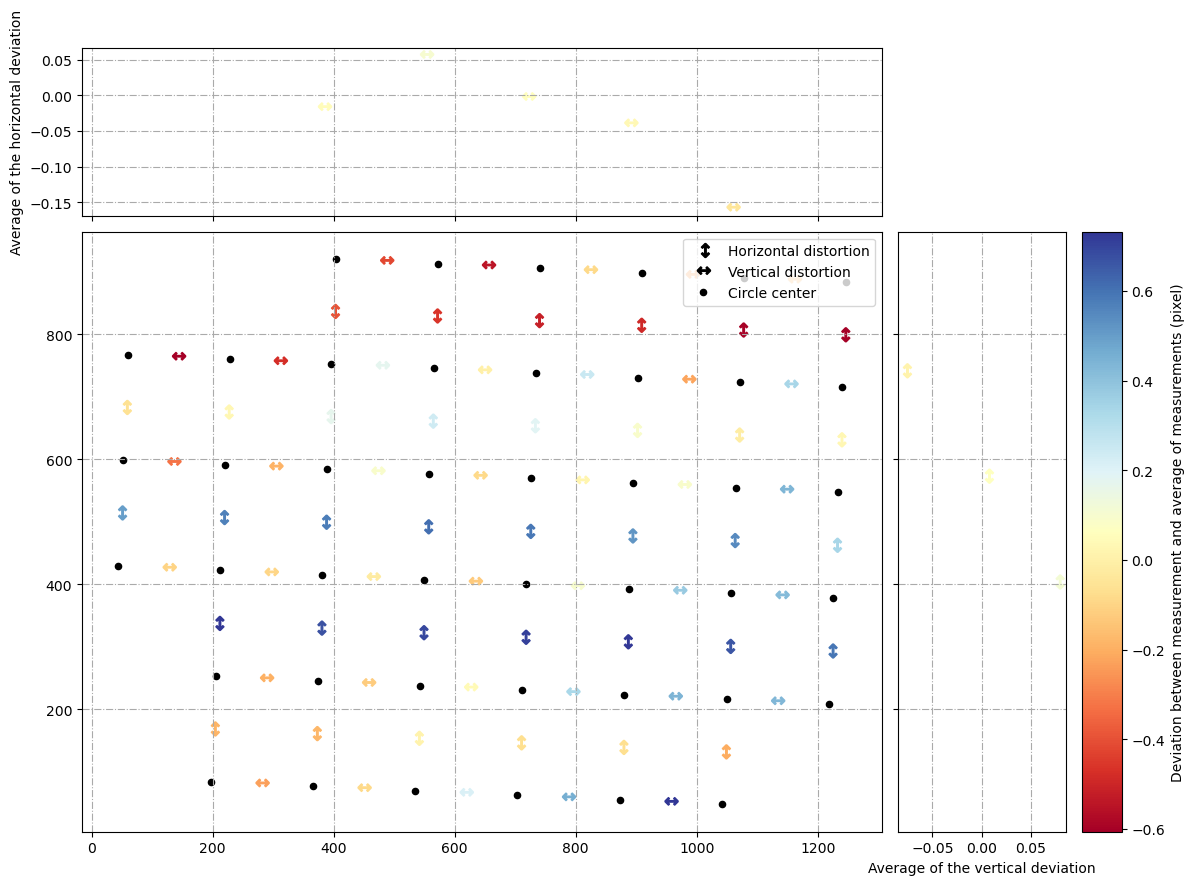

In [20]:
if __name__ == "__main__":
    h_bary = functions.get_barycentres(circles_mat[1:, :, 0:2],
                 circles_mat[:-1, :, 0:2])
    h_distor = [h_dist, h_bary]

    v_bary = functions.get_barycentres(circles_mat[:, 1:, 0:2],
                 circles_mat[:, :-1, 0:2])
    v_distor = [v_dist, v_bary]

    fig = plt.figure(figsize=(8,8))
    nullfmt = plt.NullFormatter()
    # definitions of the axis
    left, width = 0.3, 1
    bottom, height = 0.1, 0.75
    rect_scatter = [left, bottom, width, height]
    rect_ploth = [left, bottom+height+0.02, width, 0.21]
    rect_plotv = [left+width+0.02, bottom, 0.21, height]
    rect_cbar =  [left+width+0.25, bottom, 0.05, height]
    axCbar = plt.axes(rect_cbar)
    
    # Main graph
    
    ax_princip = plt.axes(rect_scatter)
    ax_princip.grid(visible=True, which='major', color='#AAAAAA', linestyle = 'dashdot')
    handles = []
    # Horizontal distortion
    graph = functions.plot_oriented_distortion(h_distor, "h", pixel_nb)
    handle, label = graph.legend_elements(prop="sizes", alpha=1)
    handles.append(handle[0])
    # Vertical distortion
    graph = functions.plot_oriented_distortion(v_distor, "v", pixel_nb)
    handle, label = graph.legend_elements(prop="sizes", alpha=1)
    handles.append(handle[0])
    label = "Deviation between measurement and average of measurements (pixel)"
    cm = plt.cm.get_cmap('RdYlBu')
    plt.colorbar(graph, cax=axCbar, cmap=cm, label=label)
    circles_graph = ax_princip.scatter(circles_mat[:, :, 0], circles_mat[:, :, 1],
                       c='k', marker="o", s=20,
                       label="Circle center")
    handle, label = circles_graph.legend_elements(prop="sizes", alpha=1)
    handles.append(handle[0])
    labels = ["Horizontal distortion", "Vertical distortion",
             "Circle center"]
    legend2 = ax_princip.legend(handles, labels, loc="upper right")

     
    # Evolution of average vertical measurements as a function of y axis 
        
    axHisth = plt.axes(rect_ploth)
    axHisth.grid(visible=True, which='major', color='#AAAAAA', linestyle = 'dashdot')
    functions.plot_mean_distortion(h_distor, "h", pixel_nb)
    axHisth.xaxis.set_major_formatter(nullfmt)
    axHisth.set_xlim(ax_princip.get_xlim())

     
    # Evolution of average vertical measurements as a function of x axis 
            
    axHistv = plt.axes(rect_plotv)
    functions.plot_mean_distortion(v_distor, "v", pixel_nb)
    axHistv.set_ylim(ax_princip.get_ylim())
    axHistv.grid(visible=True, which='major', color='#AAAAAA', linestyle = 'dashdot')
    axHistv.yaxis.set_major_formatter(nullfmt)
    
    #Legend
    # ax_princip.legend(loc="upper right")
    plt.show()